### Simple Feature Importance

In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
from fastai.tabular import *

In [15]:
from fastai import tabular

In [16]:
from exp.nb_ import *

In [17]:
path=Path('../data/football/')

In [18]:
train_df = pd.read_pickle(path/'trans_over_1000_final.pkl')

In [19]:
cat_vars_tpl = ('season','trs_year','trs_month','trs_day','trs_till_deadline',
            'contract_left_months', 'contract_left_years','age',
            'is_midseason','is_loan','is_end_of_loan',
            'nat_national_name','plr_position_main',
            'plr_other_positions','plr_nationality_name',
            'plr_other_nationality_name','plr_place_of_birth_country_name',
            'plr_foot','plr_height','plr_player_agent','from_club_name','from_club_is_first_team',
            'from_clb_place','from_clb_qualified_to','from_clb_is_champion','from_clb_is_cup_winner',
            'from_clb_is_promoted','from_clb_lg_name','from_clb_lg_country','from_clb_lg_group',
            'from_coach_name', 'from_sport_dir_name',
            'to_club_name','to_club_is_first_team','to_clb_place','to_clb_qualified_to',
            'to_clb_is_champion','to_clb_is_cup_winner','to_clb_is_promoted','to_clb_lg_name','to_clb_lg_country',
            'to_clb_lg_group','to_coach_name', 'to_sport_dir_name',
            'plr_position_0','plr_position_1','plr_position_2',
            'stats_leag_name_0','stats_leag_grp_0','stats_leag_name_1','stats_leag_grp_1','stats_leag_name_2',
            'stats_leag_grp_2')
cont_vars_tpl = ('nat_months_from_debut','nat_matches_played','nat_goals_scored','from_clb_pts_avg',
             'from_clb_goals_diff_avg','to_clb_pts_avg','to_clb_goals_diff_avg','plr_apps_0',
             'plr_apps_1','plr_apps_2','stats_made_goals_0','stats_conc_gols_0','stats_cards_0',
             'stats_minutes_0','stats_team_points_0','stats_made_goals_1','stats_conc_gols_1',
             'stats_cards_1','stats_minutes_1','stats_team_points_1','stats_made_goals_2',
             'stats_conc_gols_2','stats_cards_2','stats_minutes_2','stats_team_points_2', 'pop_log1p')

In [20]:
cat_vars = list(cat_vars_tpl)
cont_vars = list(cont_vars_tpl)
all_vars = cat_vars + cont_vars

In [21]:
dep_var = 'fee'

In [22]:
df = train_df[all_vars + [dep_var]].copy()

In [23]:
np.random.seed(1001)
ln = len(df)
valid_idx = np.random.choice(ln, int(ln*0.2), replace=False)

In [24]:
procs=[FillMissing, Categorify, Normalize]

In [25]:
min_log_y = np.log(500)
max_log_y = np.log(np.max(df[dep_var])*1.2)
y_range = torch.tensor([min_log_y, max_log_y], device=defaults.device)

In [26]:
BS = 128

In [27]:
def emb_sz_rule_reduced(n_cat:int)->int: return min(10, round(1.6 * n_cat**0.56))

In [28]:
#monkey pacth embenning rule as 600 floats is too much for our case
tabular.data.emb_sz_rule = emb_sz_rule_reduced

In [29]:
name = 'w_pop_ref-346-median'

In [30]:
p = ld_var(name=f'{name}_hypers', path=path)
p

{'layers': [1000, 500],
 'layers_drop': [0.07, 0.7],
 'emb_drop': 0.7,
 'cycles': 40,
 'w_decay': 0.7,
 'max_lr': 0.001}

In [31]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .databunch(bs=BS))

In [32]:
np.random.seed(1001)
learn = tabular_learner(data, 
                        layers=p['layers'], 
                        ps=p['layers_drop'], 
                        emb_drop=p['emb_drop'], 
                        y_range=y_range, 
                        metrics=exp_mmape,
                        loss_func=MAELossFlat())

In [33]:
learn = learn.load(f'{name}')

In [28]:
fi = calc_feat_importance(df=df,
                     learn=learn, 
                     dep_col=dep_var,
                     func=exp_mmape,
                     bs=BS,
                     rounds=10)

In [29]:
fi

OrderedDict([('from_coach_name', 0.2532547386803482),
             ('to_coach_name', 0.22926744939010277),
             ('plr_player_agent', 0.19481521417458034),
             ('to_club_name', 0.19368163744883338),
             ('from_club_name', 0.15482357956792964),
             ('stats_minutes_0', 0.12545907110437843),
             ('pop_log1p', 0.1251504598768778),
             ('nat_national_name', 0.10613940759536696),
             ('nat_matches_played', 0.09077946127452848),
             ('to_sport_dir_name', 0.08958552479291623),
             ('from_sport_dir_name', 0.079930674183312),
             ('age', 0.07977442738809272),
             ('trs_year', 0.06641507001438672),
             ('season', 0.06288907869329918),
             ('stats_leag_name_0', 0.058282252180715935),
             ('to_clb_pts_avg', 0.056330815413420374),
             ('nat_months_from_debut', 0.054966128214669764),
             ('stats_minutes_1', 0.054610782127652094),
             ('stats_made_goals

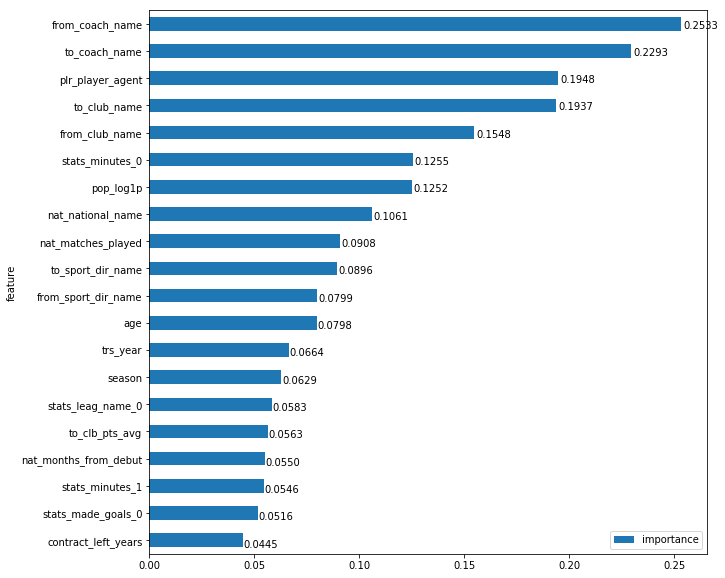

In [30]:
plot_importance(ord_dic_to_df(fi), asc=False)

It's very interesting that to/from coachname and clubname are so hight.
Just don't remember that model takes the whole decade as an input ant try to interpert it pretty much as one, so often we can see only general insights of the whole decade.
The player agent is also a very interesting field (I think even more interesting than the previous ones), because it is really independent from other features (as coaches and clubs and sport managers, I think, are often interconnected) and we can be more sure that inspecting it, we inspect this feature alone.
The top continious features are: minutes played in the main tournament and popularity, which makes sense.

### After Dendrogram

Let's treat season and trs_year as one entity in tearms of feture importance. As one is really nerly defines other (they bith are very correlated wuth each other). And model just splits importance of one thing into these two features.

In [34]:
fields = [
    ['season', 'trs_year'],
     'trs_month',
     'trs_day',
     'trs_till_deadline',
     ['contract_left_months', 'contract_left_years'],
     'age',
     'is_midseason',
     'is_loan',
     'is_end_of_loan',
     'nat_national_name', 
     ['plr_position_main', 'plr_position_0'],
     'plr_other_positions',
     ['plr_nationality_name', 'plr_place_of_birth_country_name'],
     'plr_other_nationality_name',
     'plr_foot',
     'plr_height',
     'plr_player_agent',
     ['from_club_name', 'from_club_is_first_team', 'from_clb_lg_name', 'from_clb_lg_country', 'from_clb_lg_group'],
     ['from_clb_place', 'from_clb_qualified_to', 'from_clb_is_champion', 'from_clb_is_cup_winner', 'from_clb_is_promoted'] ,
     'from_coach_name',
     'from_sport_dir_name',
     ['to_club_name', 'to_club_is_first_team', 'to_clb_lg_name',  'to_clb_lg_country', 'to_clb_lg_group'],
     ['to_clb_place', 'to_clb_qualified_to', 'to_clb_is_champion', 'to_clb_is_cup_winner', 'to_clb_is_promoted'] ,
     'to_coach_name',
     'to_sport_dir_name',
     'plr_position_1',
     'plr_position_2',
     ['stats_leag_name_0', 'stats_leag_grp_0'],
     ['stats_leag_name_1', 'stats_leag_grp_1'],
     ['stats_leag_name_2', 'stats_leag_grp_2'],
     'nat_months_from_debut',
     'nat_matches_played',
     'nat_goals_scored',
     'from_clb_pts_avg',
     'from_clb_goals_diff_avg',
     'to_clb_pts_avg',
     'to_clb_goals_diff_avg',
     'plr_apps_0',
     'plr_apps_1',
     'plr_apps_2',
     'stats_made_goals_0',
     'stats_conc_gols_0',
     'stats_cards_0',
     'stats_minutes_0',
     'stats_team_points_0',
     'stats_made_goals_1',
     'stats_conc_gols_1',
     'stats_cards_1',
     'stats_minutes_1',
     'stats_team_points_1',
     'stats_made_goals_2',
     'stats_conc_gols_2',
     'stats_cards_2',
     'stats_minutes_2',
     'stats_team_points_2',
     'pop_log1p'
 ]

In [36]:
imp_simple_conc = calc_fi_custom(df=df,
               learn=learn, 
               dep_col=dep_var,
               fields=fields,
               func=exp_mmape,
               bs=BS,
               rounds=10)

In [37]:
imp_simple_conc

OrderedDict([('to_club_name, to_club_is_first_team, to_clb_lg_name, to_clb_lg_country, to_clb_lg_group',
              0.5155210336181214),
             ('from_coach_name', 0.3720307988262844),
             ('season, trs_year', 0.35396791675234346),
             ('to_coach_name', 0.33075302370137494),
             ('plr_player_agent', 0.2901645287255285),
             ('from_club_name, from_club_is_first_team, from_clb_lg_name, from_clb_lg_country, from_clb_lg_group',
              0.27367754786613563),
             ('stats_minutes_0', 0.25280648018843377),
             ('pop_log1p', 0.25066028808850227),
             ('nat_matches_played', 0.17987181123878446),
             ('nat_months_from_debut', 0.16820745256752714),
             ('nat_national_name', 0.153525093481123),
             ('stats_made_goals_0', 0.15141924663521555),
             ('age', 0.14200145593742783),
             ('to_sport_dir_name', 0.14113335080977993),
             ('stats_minutes_1', 0.1261433347983663),
 

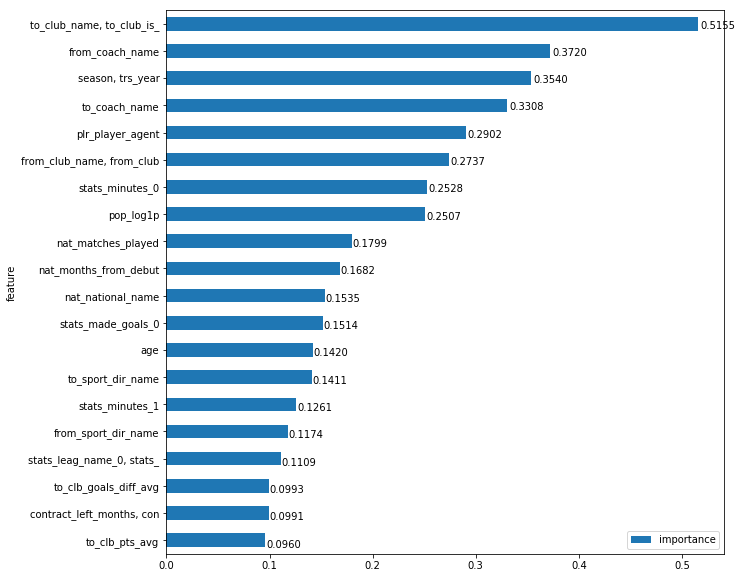

In [38]:
plot_importance(ord_dic_to_df(imp_simple_conc), asc=False)

In [40]:
sv_var(var=imp_simple_conc, name='imp_simple_conc', path=path)

In [42]:
imp_simple_conc = ld_var(name='imp_simple_conc', path=path)